In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
latent_dim = 100        # Dimensi ruang laten
hidden_dim = 256        # Jumlah neuron di hidden layer
image_dim = 28 * 28     # Image dimension
batch_size = 64
learning_rate = 0.0002
num_epochs = 50

In [7]:
# Load Dataset

# Gabung beberapa data jadi satu
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

# Transform gambar ke bentuk PIL image/numpy array jadi tensor pytorch
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# menormalisasi tensor gambar dengan rata-rata 0.5 dan standar deviasi 0.5
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Buat gambar

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()                                 # [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [11]:
# Predict gambar

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()                               # [0, 1]
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [12]:
generator = Generator()
discriminator = Discriminator()

In [13]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
adversarial_loss = nn.BCELoss()

In [14]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        real_imgs = imgs

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

Epoch 1/50, D Loss: 0.056094929575920105, G Loss: 3.311225414276123
Epoch 2/50, D Loss: 0.20326083898544312, G Loss: 1.9476912021636963
Epoch 3/50, D Loss: 0.19056977331638336, G Loss: 2.1328141689300537
Epoch 4/50, D Loss: 0.31499746441841125, G Loss: 3.184607982635498
Epoch 5/50, D Loss: 0.23047588765621185, G Loss: 4.906177520751953
Epoch 6/50, D Loss: 0.02480234205722809, G Loss: 4.015898704528809
Epoch 7/50, D Loss: 0.08006057143211365, G Loss: 3.142094850540161
Epoch 8/50, D Loss: 0.035127393901348114, G Loss: 4.247681617736816
Epoch 9/50, D Loss: 0.05527834966778755, G Loss: 4.712566375732422
Epoch 10/50, D Loss: 0.08159162104129791, G Loss: 5.839337348937988
Epoch 11/50, D Loss: 0.19414782524108887, G Loss: 4.434957981109619
Epoch 12/50, D Loss: 0.23473131656646729, G Loss: 5.644586563110352
Epoch 13/50, D Loss: 0.14103801548480988, G Loss: 3.1120917797088623
Epoch 14/50, D Loss: 0.17085999250411987, G Loss: 4.490876197814941
Epoch 15/50, D Loss: 0.13217702507972717, G Loss: 3.

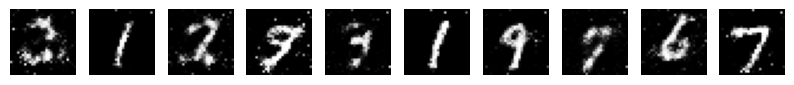

In [17]:
# Generate new images
def generate_images(generator, num_images, latent_dim):
    # Menentukan status generator menjadi evaluation mode
    generator.eval()

    # Generate random noise
    z = torch.randn(num_images, latent_dim)

    # Generate images from noise
    gen_imgs = generator(z)

    # Rescale images menjadi rentang [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axs[i].imshow(gen_imgs[i].detach().numpy().squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

# Generate dan menampilkan 10 gambar baru
generate_images(generator, 10, latent_dim)